In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
batch_size = 4
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

data = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_indices = list(range(len(data)))[:45000]
validation_indices = list(range(len(data)))[45000:]

# train_sample = torch.utils.data.SubsetRandomSampler(train_indices)
# validation_sample = torch.utils.data.SubsetRandomSampler(validation_indices)


# Subsets of the whole train data using the sampled indices
trainset = torch.utils.data.Subset(data, train_indices)
validationset = torch.utils.data.Subset(data, validation_indices)

# Dataloader using the created subsets
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print('Train set size: ', len(trainloader) * 4)
print('Validation set size: ', len(validationloader) * 4)
print('Test set size: ', len(testloader) * 4)

Train set size:  45000
Validation set size:  5000
Test set size:  10000


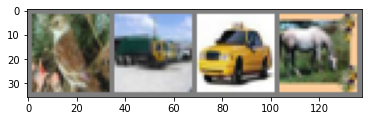

 bird truck   car horse


In [4]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [5]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [6]:
class NetMod(nn.Module):
    def __init__(self):
        super(NetMod, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=96, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(in_features=4096, out_features=4096)
        self.fc2 = nn.Linear(in_features=4096, out_features=4096)
        self.fc3 = nn.Linear(in_features=4096, out_features=10)
        self.dropout1 = nn.Dropout(p=0.5)
        self.dropout2 = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(F.relu(x))
        x = self.dropout2(x)
        x = self.fc3(F.relu(x))
        x = F.relu(x)
        return x

net = NetMod()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

NetMod(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [7]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)

In [8]:
avg_losses = []   # Avg. losses.
epochs = 30       # Total epochs.
print_freq = 2000  # Print frequency.
valid_losses = []
train_losses = []

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    validation_loss = 0.0
    train_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        train_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.5f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0
            
    net.eval()
    with torch.no_grad():
        for i, data in enumerate(validationloader, 0):
            # Get the inputs.
            inputs, labels = data

            # Move the inputs to the specified device.
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward step.
            outputs = net(inputs)
            loss = loss_func(outputs, labels)
            validation_loss += loss.item()
    net.train()
    print('Validation Loss: ', validation_loss, '----', 'Train Loss: ', train_loss)
    valid_losses.append(validation_loss)
    train_losses.append(train_loss)
    
    

print('Finished Training.')

[epoch: 0, i:  1999] avg mini-batch loss: 2.30265
[epoch: 0, i:  3999] avg mini-batch loss: 2.30225
[epoch: 0, i:  5999] avg mini-batch loss: 2.30103
[epoch: 0, i:  7999] avg mini-batch loss: 2.24461
[epoch: 0, i:  9999] avg mini-batch loss: 2.07836
Validation Loss:  2466.326477110386 ---- Train Loss:  24888.301890790462
[epoch: 1, i:  1999] avg mini-batch loss: 1.81904
[epoch: 1, i:  3999] avg mini-batch loss: 1.72500
[epoch: 1, i:  5999] avg mini-batch loss: 1.58405
[epoch: 1, i:  7999] avg mini-batch loss: 1.47108
[epoch: 1, i:  9999] avg mini-batch loss: 1.39648
Validation Loss:  1575.625392884016 ---- Train Loss:  17659.822059206665
[epoch: 2, i:  1999] avg mini-batch loss: 1.27482
[epoch: 2, i:  3999] avg mini-batch loss: 1.21925
[epoch: 2, i:  5999] avg mini-batch loss: 1.15311
[epoch: 2, i:  7999] avg mini-batch loss: 1.12992
[epoch: 2, i:  9999] avg mini-batch loss: 1.09445
Validation Loss:  1285.7225519884378 ---- Train Loss:  13061.678596993908
[epoch: 3, i:  1999] avg mini-

[epoch: 25, i:  5999] avg mini-batch loss: 0.06325
[epoch: 25, i:  7999] avg mini-batch loss: 0.05916
[epoch: 25, i:  9999] avg mini-batch loss: 0.07557
Validation Loss:  1016.4553701805954 ---- Train Loss:  643.3280281833675
[epoch: 26, i:  1999] avg mini-batch loss: 0.06057
[epoch: 26, i:  3999] avg mini-batch loss: 0.03747
[epoch: 26, i:  5999] avg mini-batch loss: 0.05818
[epoch: 26, i:  7999] avg mini-batch loss: 0.06362
[epoch: 26, i:  9999] avg mini-batch loss: 0.07456
Validation Loss:  1017.3570139937456 ---- Train Loss:  675.164796275672
[epoch: 27, i:  1999] avg mini-batch loss: 0.04289
[epoch: 27, i:  3999] avg mini-batch loss: 0.03763
[epoch: 27, i:  5999] avg mini-batch loss: 0.04245
[epoch: 27, i:  7999] avg mini-batch loss: 0.06437
[epoch: 27, i:  9999] avg mini-batch loss: 0.07211
Validation Loss:  958.1392866388969 ---- Train Loss:  615.0609306291923
[epoch: 28, i:  1999] avg mini-batch loss: 0.04884
[epoch: 28, i:  3999] avg mini-batch loss: 0.04001
[epoch: 28, i:  59

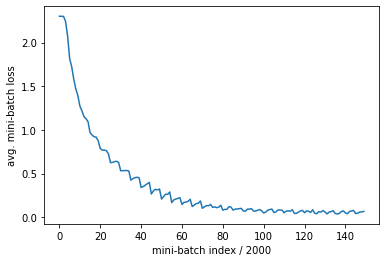

In [9]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

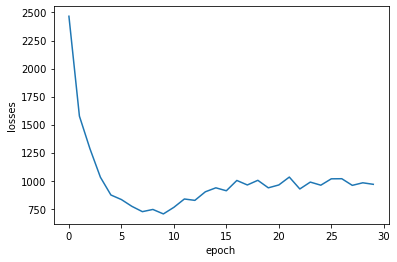

In [10]:
plt.plot(valid_losses)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.show()

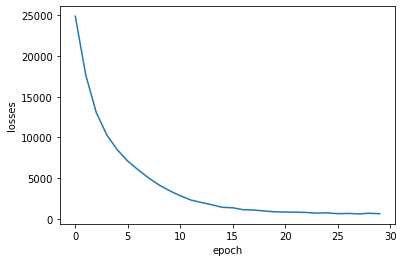

In [11]:
plt.plot(train_losses)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.show()

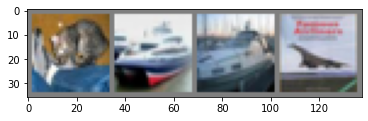

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane


NetMod(
  (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(96, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [12]:
# Check several images.
net.eval()
with torch.no_grad():
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))
    outputs = net(images.to(device))
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(batch_size)))
net.train()

In [13]:
# Get test accuracy.
correct = 0
total = 0

net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

net.train()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 81 %


In [14]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 85 %
Accuracy of   car : 87 %
Accuracy of  bird : 73 %
Accuracy of   cat : 52 %
Accuracy of  deer : 83 %
Accuracy of   dog : 77 %
Accuracy of  frog : 81 %
Accuracy of horse : 86 %
Accuracy of  ship : 88 %
Accuracy of truck : 88 %
